In [40]:
# Import the necessary modules and libraries
import matplotlib.pyplot as plt

params = {'legend.fontsize': 'large',
          'legend.loc': 'upper right',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

###############################################

def trueFunction(x):
    return np.sin(x)

def noisyFunction(x, sigma=0.5):
    GaussianNoise = rng.normal(0.0, sigma, len(x)).reshape(len(x), 1) 
    return np.add( trueFunction(x), GaussianNoise )

###############################################
                  
def getTrainingData(n=100, sigma=0.5):
    
    # Generate n random points on the x-axis
    data        = np.sort(15 * rng.rand(n, 1), axis=0)
    noisylabels = noisyFunction(data, sigma)
    
    return data, noisylabels

###############################################

def getNoiseBiasVariance(numTrials = 50, numDepths = 16):

    testdata = np.arange(0.0, 15, 0.01)[:, np.newaxis]
                  
    
    testlabels = trueFunction(testdata)
    noisyTestlabels = noisyFunction(testdata)

    ###############
    
    ExpectedF = np.zeros( (numDepths, testlabels.shape[0]) )
    ExpectedFsquared = np.zeros( (numDepths, testlabels.shape[0]) )

    risks = np.zeros( (numTrials, numDepths) )
    trainingrisks = np.zeros( (numTrials, numDepths) )

    for thisTrial in range(0, numTrials):
        
        # make a random training set
        traindata, trainlabels = getTrainingData()
        
        numTrainingPoints = trainlabels.shape[0]
        

        for thisDepth in range(0, numDepths):
            
            #build model
            model = DecisionTreeRegressor( max_depth = thisDepth+1, max_features='auto' ).fit(traindata, trainlabels)
            #model = make_pipeline(PolynomialFeatures(1+thisDepth), Ridge( alpha=1 , normalize=True) )

            #train model
            model = model.fit(traindata, trainlabels)

            #get predictions for this model
            predictedlabels = model.predict(testdata).reshape((len(testdata,)))        

            #estimate risk for this model
            risks[thisTrial, thisDepth] = mean_squared_error(predictedlabels, noisyTestlabels)
            
            #get training error
            trainingrisks[thisTrial, thisDepth] = mean_squared_error(model.predict(traindata).reshape((numTrainingPoints,)), trainlabels)
                        
            #add predictions to the expected model            
            ExpectedF[thisDepth,:]        = np.add( ExpectedF[thisDepth,:],        predictedlabels ) 
            ExpectedFsquared[thisDepth,:] = np.add( ExpectedFsquared[thisDepth,:], np.power(predictedlabels,2) )
    
    #divide final expected model predictions by numTrials so they are averages
    ExpectedF        = np.divide( ExpectedF, numTrials )
    ExpectedFsquared = np.divide( ExpectedFsquared, numTrials )
    
    
    expectedRisk = np.mean(risks, axis=0)
    bias = np.zeros(numDepths)
    variance = np.zeros(numDepths)    
    noise = np.zeros(numDepths)    
    
    for thisDepth in range(0, numDepths):
        
        EF   = ExpectedF[thisDepth,:]
        EFsq = ExpectedFsquared[thisDepth,:]

        bias[thisDepth] = mean_squared_error( EF, testlabels )
        
        variance[thisDepth] = np.mean( np.subtract(EFsq, np.power(EF,2)))
    
        noise[thisDepth] = expectedRisk[thisDepth] - (bias[thisDepth] + variance[thisDepth])
    
    return risks, noise, bias, variance, trainingrisks

###############################################
    

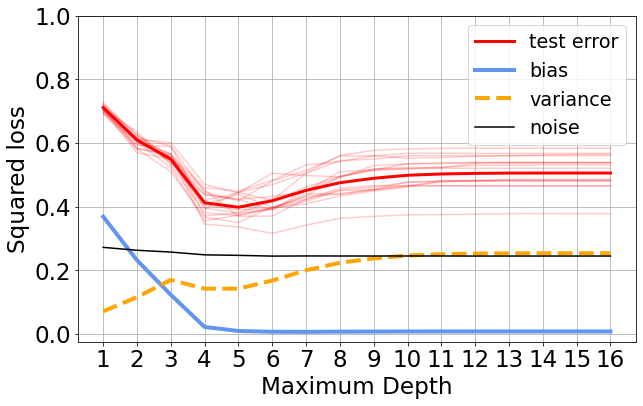

In [42]:
rng = np.random.RandomState(np.random.randint(213))

numTrials = 50
numDepths = 16

plt.xticks(range(1, numDepths+1, 1))
plt.xlabel('Maximum Depth')
plt.ylabel('Squared loss')
plt.ylim(-0.025,1)
plt.grid()

modelRisks, noise, bias, variance, trainingrisks = getNoiseBiasVariance(numTrials, numDepths)

for trial in range(0, modelRisks.shape[1]):
    #plot risk over each trial
    plt.plot( range(1,numDepths+1), modelRisks[trial,:], alpha=0.2,      color='red' )

#plot expected risk
plt.plot( range(1,numDepths+1), np.mean(modelRisks, axis=0),    color='red', alpha=1, linewidth=3, label='test error')
#plot bias
plt.plot( range(1,numDepths+1), bias,    color='cornflowerblue', linewidth=4, label='bias')
#plot variance
plt.plot( range(1,numDepths+1), variance,    color='orange', linestyle='dashed', linewidth=4, label='variance')
#plot noise
plt.plot( range(1,numDepths+1), noise,    color='black', label='noise')


#plot training error if you really want to
#for trial in range(0, trainingrisks.shape[1]):
    #plot risk over each trial
#   plt.plot( range(1,numDepths+1), trainingrisks[trial,:], alpha=0.2,   linestyle='dashed',     color='red' )
#plt.plot( range(1,numDepths+1), np.mean(trainingrisks, axis=0),    color='red', alpha=1,  linestyle='dashed', linewidth=3, label='training error')

plt.legend()

plt.show()




Risk  0.25851768207725906


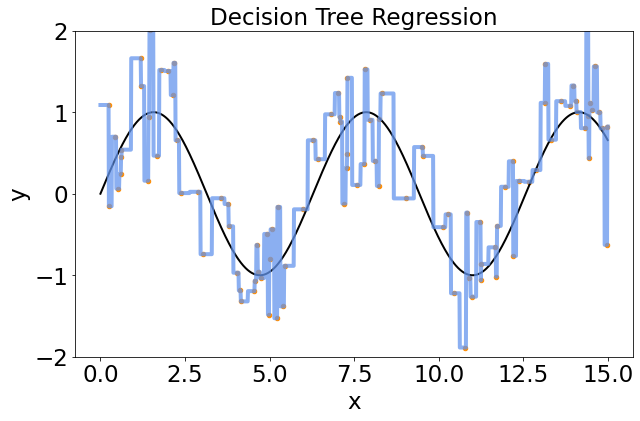

In [45]:
#rng = np.random.RandomState(431)

traindata, trainlabels = getTrainingData()

testdata = np.arange(0.0, 15, 0.01)[:, np.newaxis]

model = DecisionTreeRegressor(max_depth = 16).fit(traindata, trainlabels)
#model = make_pipeline(PolynomialFeatures(10), LinearRegression()).fit(traindata, trainlabels)

predictedlabels = model.predict(testdata)
testlabels = np.sin(testdata)

print('Risk ', mean_squared_error(predictedlabels,testlabels))

# Plot the results
plt.figure()
plt.plot( testdata, testlabels, color='black', label='y(x)', linewidth=2)
plt.scatter(traindata, trainlabels, s=20,  c="darkorange", label="data")
plt.plot( testdata, predictedlabels, color="cornflowerblue", alpha=0.75, linewidth=4)

plt.xlabel("x")
plt.ylabel("y")
plt.title("Decision Tree Regression")

plt.ylim(-2,2)

plt.show()